Kicad Netlist Parser Example
============================

This example shows how to read a netlist generated from the \_ Schematic
Editor.

This example is copied from Stafford Horne\'s Blog:

:   -   <http://stffrdhrn.github.io/electronics/2015/04/28/simulating_kicad_schematics_in_spice.html>
    -   <https://github.com/stffrdhrn/kicad-spice-demo>

Note

The netlist must be generated using numbered node. Subcircuit elements
must have a reference starting by *X* and a value corresponding to the
subcircuit\'s name.


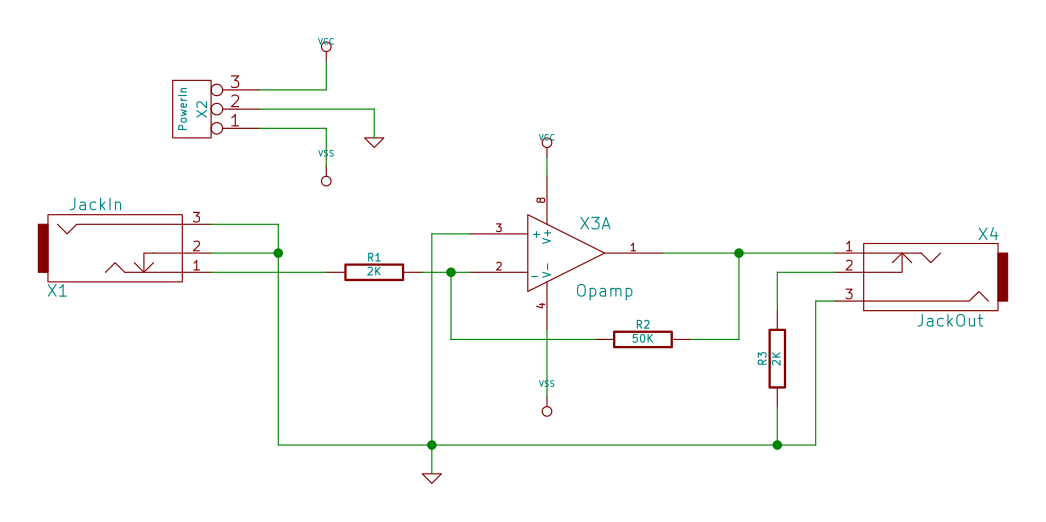

The netlist generated by Kicad is the following:


```
* /home/gv/fabrice/developpement/PySpice/examples/spice-parser/kicad-pyspice-example/kicad-pyspice-example.cir

* EESchema Netlist Version 1.1 (Spice format) creation date: dim. 29 nov. 2015 18:04:33 CET

* To exclude a component from the Spice Netlist add [Spice_Netlist_Enabled] user FIELD set to: N
* To reorder the component spice node sequence add [Spice_Node_Sequence] user FIELD and define sequence: 2,1,0

* Sheet Name: /
X3  7 6 5 4 1 Opamp		
X1  2 5 5 JackIn		
X4  7 3 5 JackOut		
R2  6 7 50K		
R1  2 6 2K		
R3  5 3 2K		
X2  4 5 1 PowerIn		

.end
```


In [ ]:


from pathlib import Path

import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Parser import SpiceParser
from PySpice.Unit import *


libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)




We implement the *PowerIn*, *Opamp*, *JackIn* and *JackOut* elements as
subcircuit.


In [ ]:

class PowerIn(SubCircuitFactory):

    __name__ = 'PowerIn'
    __nodes__ = ('output_plus', 'ground', 'output_minus')


    def __init__(self):

        super().__init__()

        self.V('positive', 'output_plus', 'ground', 3.3@u_V)
        self.V('negative', 'ground', 'output_minus', 3.3@u_V)


class Opamp(SubCircuitFactory):

    __name__ = 'Opamp'
    __nodes__ = ('output',
                 'input_negative', 'input_positive',
                 'power_positive', 'power_negative')


    def __init__(self):

        super().__init__()

        self.X('opamp', 'LMV981',
               'input_positive', 'input_negative',
               'power_positive', 'power_negative',
               'output',
               'NSD')


class JackIn(SubCircuitFactory):

    __name__ = 'JackIn'
    __nodes__ = ('input', 'x', 'ground')


    def __init__(self):

        super().__init__()

        # could use SinusoidalVoltageSource as well
        self.V('micro', 'ground', 'input', 'DC 0V AC 1V SIN(0 0.02 440)')


class JackOut(SubCircuitFactory):

    __name__ = 'JackOut'
    __nodes__ = ('output', 'x', 'ground')


    def __init__(self):

        super().__init__()

        self.R('load', 'output', 'x', 10@u_Ω)




We read the generated netlist.


In [ ]:
directory_path = Path(__file__).resolve().parent
kicad_netlist_path = directory_path.joinpath('kicad-pyspice-example', 'kicad-pyspice-example.cir')
parser = SpiceParser(path=str(kicad_netlist_path))



We build the circuit and translate the ground (5 to 0).


In [ ]:
circuit = parser.build_circuit(ground=5)



We include the operational amplifier module.


In [ ]:
circuit.include(spice_library['LMV981'])



We define the subcircuits.


In [ ]:
for subcircuit in (PowerIn(), Opamp(), JackIn(), JackOut()):
    circuit.subcircuit(subcircuit)

# print(str(circuit))



We perform a transient simulation.


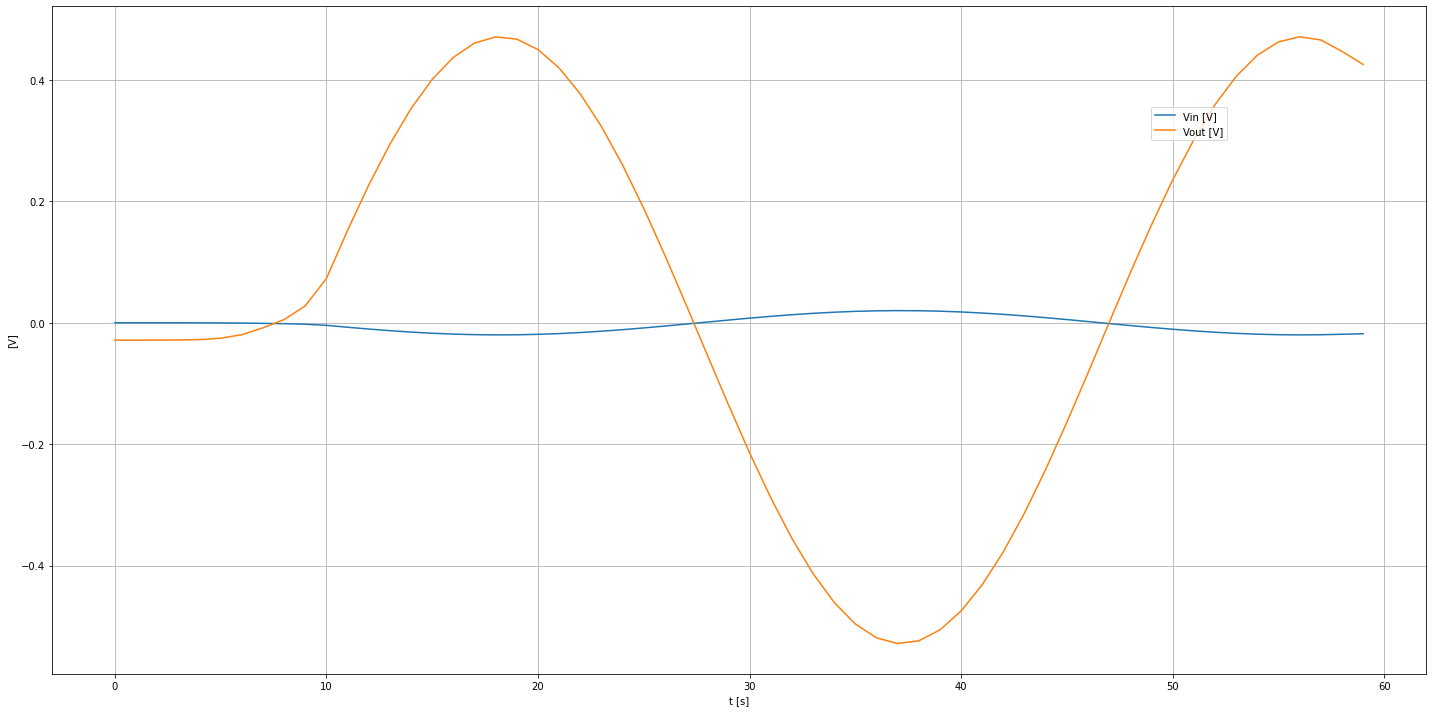

In [ ]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=100@u_us, end_time=3@u_ms)

figure, ax = plt.subplots(figsize=(20, 10))
ax.plot(analysis['2']) # JackIn input
ax.plot(analysis['7']) # Opamp output
ax.legend(('Vin [V]', 'Vout [V]'), loc=(.8,.8))
ax.grid()
ax.set_xlabel('t [s]')
ax.set_ylabel('[V]')

plt.tight_layout()

